# chloride module example
This example demonstrates the following steps:
+ raw parameter data
+ initialize model
+ run model
+ calibrate model
+ post-process model results

In [1]:
%matplotlib inline

# Import necessary class and function from the chloride model
from rational_rc.chloride import ChlorideModel, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0
from rational_rc import math_helper as mh  # import helper module

import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


In [2]:
# Define raw parameters for the chloride ingress model
class Param: 
    pass

pars_raw = Param()

# Chloride sources
# 1) Marine environment
pars_raw.marine = False  # Set to True if the environment is marine or coastal
pars_raw.C_0_M = 18.980  # Natural chloride concentration of seawater [g/L]

# 2) de-icing salt (hard to quantify)
pars_raw.C_0_R = 0       # average chloride content of the chloride contaminated water [g/L]
pars_raw.n = 0           # average number of salting events per year [-]
pars_raw.C_R_i = 0       # average amount of chloride spread within one spreading event [g/m2]
pars_raw.h_S_i = 1       # amount of water from rain and melted snow per spreading period [L/m2]

# imported correlation function for chloride content from solution to concrete
pars_raw.C_eqv_to_C_S_0 = C_eqv_to_C_S_0

# Exposure conditions
pars_raw.exposure_condition = 'splash'  # Types: "submerged", "leakage", "spray", etc.
pars_raw.exposure_condition_geom_sensitive = True
pars_raw.T_real = 273 + 25              # Ambient temperature in Kelvin (25°C)

# Geometry of exposure (distance from the road)
pars_raw.x_a = 10.  # Horizontal distance from roadside [cm]
pars_raw.x_h = 10.  # Height above road surface [cm]

# Material properties
pars_raw.D_RCM_test = 'N/A'                          # RCM test result (diffusivity, if available) [m^2/s]
pars_raw.concrete_type = 'Portland cement concrete'  # Concrete type
pars_raw.cement_concrete_ratio = 300. / 2400.        # Cement-to-concrete ratio
pars_raw.C_max_option = 'empirical'                  # Option for empirical or user-input max chloride content
pars_raw.C_max_user_input = None                     # Maximum chloride content from testing (optional)
pars_raw.C_0 = 0                                     # Initial chloride content in concrete [wt-%/cement]

# Imported critical chloride content distribution parameters
pars_raw.C_crit_distrib_param = C_crit_param()       # Critical chloride content mean [0.6 wt-% cement]

# Built-in material properties for diffusivity
pars_raw.option = Param()
pars_raw.option.choose = True                    # Interpolate from built-in diffusivity data
pars_raw.option.cement_type = 'CEM_I_42.5_R+SF'  # Cement type
pars_raw.option.wc_eqv = 0.4                     # Equivalent water-to-cement ratio
pars_raw.option.df_D_RCM_0 = load_df_D_RCM()     # Load built-in diffusivity data


Pf(g = R-S < 0) from various methods
    sample count: 0.52769
    g integral: 0.5297243365554136
    R S integral: 0.5291643389853589
    beta_factor: -0.3170902142206623
-0.2777693343186119 0.5997325205546747


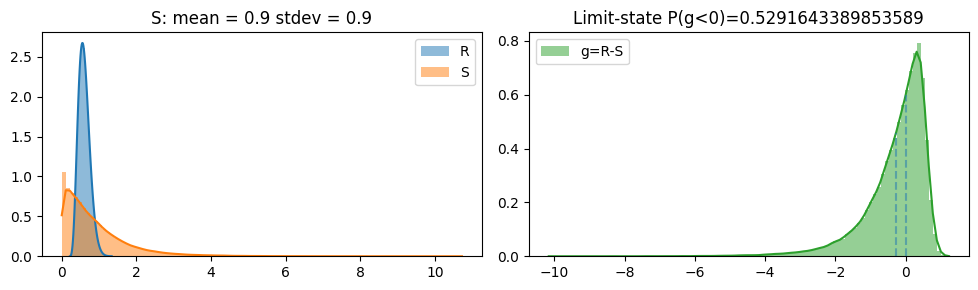

In [3]:
# Initialize the chloride ingress model with the defined parameters
model_cl = ChlorideModel(pars_raw)

# Run the chloride model for a depth of 40 mm from concrete surface and a time period of 10 years
model_cl.run(x=40, t=10)

# Post-process and plot the results
model_cl.postproc(plot=True)

In [4]:
# Calibration
# Field data at three depth at t = 10 years
chloride_content_field = pd.DataFrame()
chloride_content_field['depth'] = [12.5, 50, 100]  # [mm]
chloride_content_field['cl'] = np.array([0.226, 0.04, 0.014]) / pars_raw.cement_concrete_ratio  # chloride_content[wt.-%/cement]
print(chloride_content_field)

   depth     cl
0   12.5  1.808
1   50.0  0.320
2  100.0  0.112


In [5]:
# Calibrate the chloride model to the field chloride content data at 10 years
# Field data is provided in the DataFrame 'chloride_content_field'
model_cl_cal = model_cl.calibrate(
    10,                           # Time in years for calibration
    chloride_content_field,       # Field chloride content data for calibration
    print_proc=False,             # Disable detailed output during calibration
    plot=False                    # Disable plotting calibration
)


7.60986328125e-13
2.8806152343749997e-12
2.999267578125e-12


Pf(g = R-S < 0) from various methods
    sample count: 0.24499
    g integral: 0.2481060539788665
    R S integral: 0.24765811894306716
    beta_factor: 0.18504124398639052
0.1360381679470246 0.4568325503238138


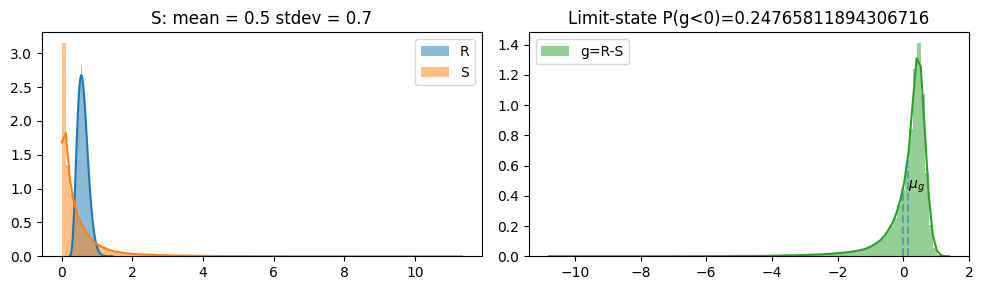

In [6]:
# Run the calibrated chloride model at 40 mm depth from concrete cover over a 10-year period
model_cl_cal.run(x=40, t=10)

# Post-process and plot the results
model_cl_cal.postproc(plot=True)

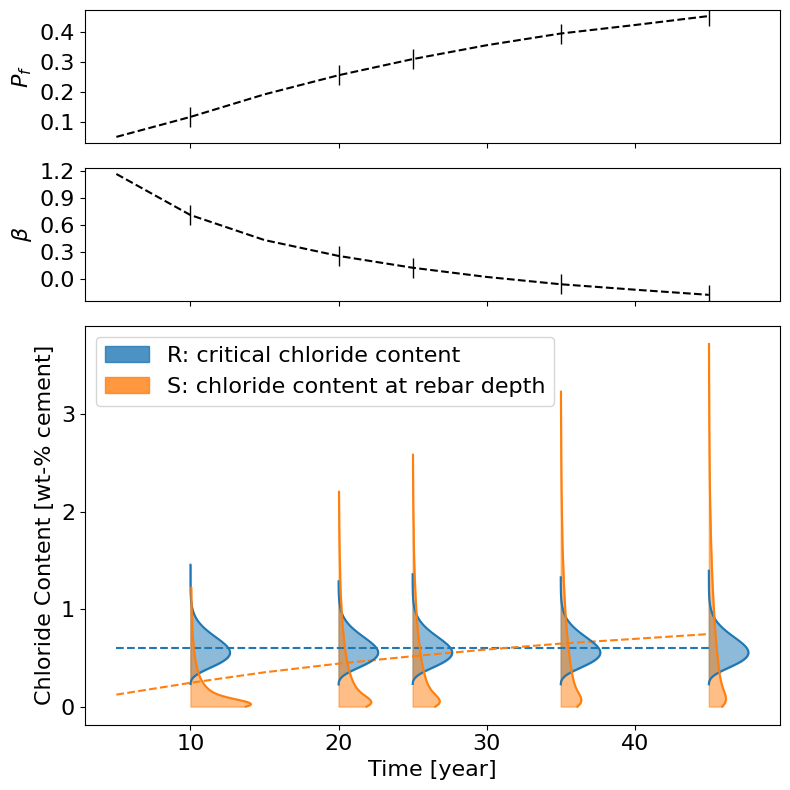

In [7]:
# Run the calibrated chloride model for a list of time steps (years)
t_lis = np.arange(5, 50, 5)  # Time steps from 5 to 50 years, in 5-year increments
cover = mh.normal_custom(50, 5, non_negative=True)  # Cover depth in mm (mean = 50 mm, std dev = 5 mm)

# Compute the probability of failure (P_f) and reliability index (β) over the time steps
pf_lis, beta_lis = model_cl_cal.chloride_with_year(
    depth=cover,        # Concrete cover depth
    year_lis=t_lis,     # List of time steps
    amplify=1           # Amplification factor for better visualization
)